## Detroit Blight Prediction

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. The project aims to predict whether a given blight ticket will be paid on time.

All data is available through the [Detroit Open Data Portal](https://data.detroitmi.gov/). The following related datasets were used to understand and determine the features used for classification :

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

Fields from all the above mentioned datasets were merged to form two data files - train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions**

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
    Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt

# import the data set
df_01 = pd.read_csv('train.csv', delimiter = ',', encoding = 'latin-1', low_memory = False)
print(df_01.shape)
df_01.head(10)

(250306, 34)


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
5,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
6,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,...,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
7,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,...,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
8,18733,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,...,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
9,28204,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Inc, Nanno",15307.0,SEVEN MILE,NaN,1537.0,E. Seven Mile,Detroit,...,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


In [4]:
# import external data files and merge them to the data set
addresses = pd.read_csv('addresses.csv', delimiter = ',', encoding = 'latin-1')
latlons = pd.read_csv('latlons.csv', delimiter = ',', encoding = 'latin-1')

# merge addresses to training dataset
df_02 = pd.merge(df_01, addresses, left_on = ['ticket_id'], right_on = ['ticket_id'], how = 'inner')

# merge latitudes and longitudes to training dataset
df_03 = pd.merge(df_02, latlons, left_on = ['address'], right_on = ['address'], how = 'inner')

# remove records where compliance equals NA
df_04 = df_03.dropna(subset = ['compliance'])

df_02.shape, df_03.shape, df_04.shape

((250306, 35), (250306, 37), (159880, 37))

In [6]:
# make all categorical variable levels with less than 10 occurrences NA in order not to end up with too many dummies later

df_05 = df_04.copy()

features_to_reduce = ['violation_description', 'agency_name', 'disposition', 'state']
    
for feature in features_to_reduce:
    number_categories_before = df_05[feature].value_counts(dropna = False).to_frame().shape[0]
    counts = df_05[feature].value_counts()
    df_05.loc[df_05[feature].isin(counts[counts < 10].to_frame().reset_index()['index']), feature] = np.nan
    number_categories_after = df_05[feature].value_counts(dropna = False).to_frame().shape[0]
    
    print('Levels of', feature, 'reduced from', number_categories_before, 'to', number_categories_after)

Levels of violation_description reduced from 207 to 98
Levels of agency_name reduced from 5 to 5
Levels of disposition reduced from 4 to 4
Levels of state reduced from 60 to 50


In [7]:
# create a new feature time_gap: the gap in days between the ticket issue date and the hearing date

def time_gap(input1, input2):
    if not input1 or type(input1) != str: return np.nan
    date1 = datetime.strptime(input1, "%Y-%m-%d %H:%M:%S")
    date2 = datetime.strptime(input2, "%Y-%m-%d %H:%M:%S")
    difference = date1 - date2
    return difference.days
    
df_05['time_gap'] = df_05.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis = 1).astype(np.float64)

In [8]:
# negative gaps (the ticket has been issued after the hearing data) and gaps of over 365 days (one year) seem incorrect.

# Number of such instances
df_05[(df_05['time_gap'] < 0) | (df_05['time_gap'] > 365)]['time_gap'].count()

453

In [9]:
# replace time gap of such instances and missing values by the average time_gap of the rest
df_05.loc[(df_05['time_gap'] < 0) | (df_05['time_gap'] > 365), 'time_gap'] = np.nan

mean_time_gap = df_05['time_gap'].mean()
df_05['time_gap'].fillna(mean_time_gap, inplace = True)

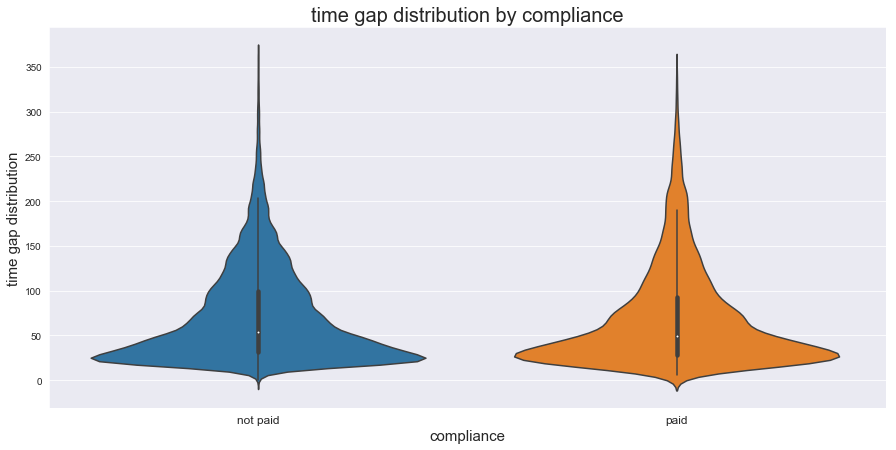

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

plt.figure(figsize = (15, 7))

p = sns.violinplot(data = df_05, x = 'compliance', y = 'time_gap')
p.set_title('time gap distribution by compliance', fontsize = 20)
p.set_xlabel('compliance', fontsize = 15)
p.set_ylabel('time gap distribution', fontsize = 15) 
p.set_xticklabels(['not paid', 'paid'], fontsize = 12)

plt.show()

In [11]:
# impute missing values in lat and lon with the average and state with a dummy state
mean_lat = df_05['lat'].mean()
mean_lon = df_05['lon'].mean()

df_05['lat'].fillna(mean_lat, inplace = True)
df_05['lon'].fillna(mean_lon, inplace = True)
df_05['state'].fillna('ZZ', inplace = True)

In [12]:
# copmute the distance of every address((lat, lon) pair) to the city of Detroit    
def haversine(lon1, lat1, lon2, lat2):

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # radius of earth in kilometers (use 3956 for miles)
    return c * r

# longitude and latitude of Detroit are -83.045753 and 42.331429
df_05['distance'] = df_05.apply(lambda row: haversine(lon1 = -83.045753,
                                                      lat1 = 42.331429,
                                                      lon2 = row['lon'],
                                                      lat2 = row['lat']), axis = 1)

In [13]:
df_05['distance'].groupby(df_05['compliance']).describe()

,count,mean,std,min,25%,50%,75%,max
compliance,,,,,,,,
0.0,148283.0,11.364780,4.296246,0.036816,8.432334,11.47135,13.964312,275.624714
1.0,11597.0,11.095243,4.536442,0.084815,7.711914,11.42643,13.943130,38.978889


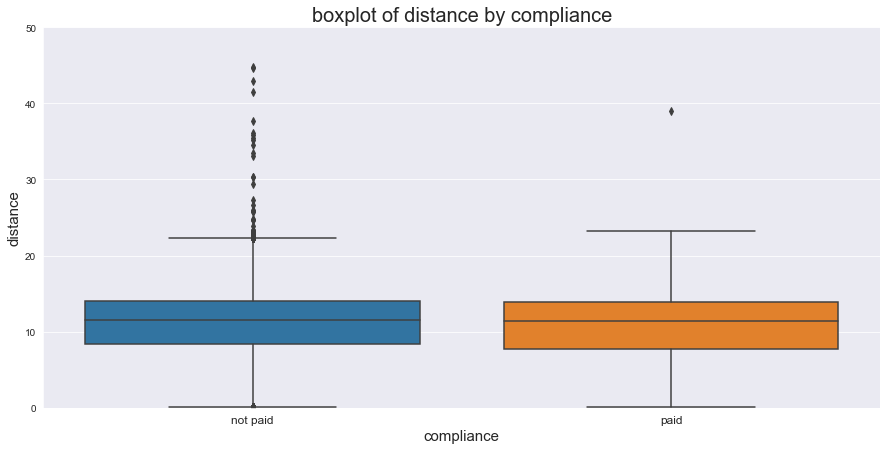

In [14]:
plt.figure(figsize = (15, 7))

bp = sns.boxplot(x = 'compliance', y = 'distance', data = df_05)
bp.set(ylim = (0, 50))
bp.set_title('boxplot of distance by compliance', fontsize = 20)
bp.set_xlabel('compliance', fontsize = 15)
bp.set_ylabel('distance', fontsize = 15) 
bp.set_xticklabels(['not paid', 'paid'], fontsize = 12)

plt.show()

In [15]:
# create some additional features
df_05.loc[:, 'distance2']          = df_05.loc[:, 'distance'] * df_05.loc[:, 'distance']
df_05.loc[:, 'distance_admin_fee'] = df_05.loc[:, 'distance'] * df_05.loc[:, 'admin_fee']
df_05.loc[:, 'distance_state_fee'] = df_05.loc[:, 'distance'] * df_05.loc[:, 'state_fee']
df_05.loc[:, 'distance_late_fee']  = df_05.loc[:, 'distance'] * df_05.loc[:, 'late_fee']
df_05.loc[:, 'distance_discount']  = df_05.loc[:, 'distance'] * df_05.loc[:, 'discount_amount']
df_05.loc[:, 'distance_judgment']  = df_05.loc[:, 'distance'] * df_05.loc[:, 'judgment_amount']
df_05.loc[:, 'distance_time_gap']  = df_05.loc[:, 'distance'] * df_05.loc[:, 'time_gap']

In [16]:
df_05.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,lon,time_gap,distance,distance2,distance_admin_fee,distance_state_fee,distance_late_fee,distance_discount,distance_judgment,distance_time_gap
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,-83.124268,71.66581,9.224702,85.095131,184.494044,92.247022,230.617555,0.0,2813.534177,661.095759
1,77242,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INV. INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,...,-83.124268,34.00000,9.224702,85.095131,184.494044,92.247022,461.235111,0.0,5350.327287,313.639875
2,77243,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MORTGAGE CO., MIDWEST",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,...,-83.124268,34.00000,9.224702,85.095131,184.494044,92.247022,230.617555,0.0,2813.534177,313.639875
4,138219,Department of Public Works,"Talbert, Reginald","INVESTMENT INC, MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S WACKER #1418,CHICAGO,...,-83.124268,136.00000,9.224702,85.095131,184.494044,92.247022,92.247022,0.0,1291.458311,1254.559502
5,177558,"Buildings, Safety Engineering & Env Department","Morris, John","INVESTMENT, MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,...,-83.124268,81.00000,9.224702,85.095131,184.494044,92.247022,276.741067,0.0,3320.892799,747.200880


In [17]:
# selecting the features
feature_names = ['ticket_id', 'violation_description', 'agency_name', 'disposition', 'discount_amount',
                 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount', 'state', 'lat', 'lon', 'distance', 'time_gap',
                 'distance2', 'distance_admin_fee', 'distance_state_fee', 'distance_late_fee', 'distance_discount',
                 'distance_judgment', 'distance_time_gap']

x = df_05[feature_names]
x = x.set_index('ticket_id')

y = df_05['compliance']

# converting the categorical features to numerical ones
x['violation_description'] = x['violation_description'].astype('category')
violation_description_dict = dict(enumerate(x.violation_description.cat.categories))
violation_description_dict2 = {y:x for x,y in violation_description_dict.items()}
x['violation_description'] = x['violation_description'].cat.codes
mode_violation_description = x['violation_description'].mode()[0]

x['agency_name'] = x['agency_name'].astype('category')
agency_name_dict = dict(enumerate(x.agency_name.cat.categories))
agency_name_dict2 = {y:x for x,y in agency_name_dict.items()}
x['agency_name'] = x['agency_name'].cat.codes
mode_agency_name = x['agency_name'].mode()[0]

x['disposition'] = x['disposition'].astype('category')
disposition_dict = dict(enumerate(x.disposition.cat.categories))
disposition_dict2 = {y:x for x,y in disposition_dict.items()}
x['disposition'] = x['disposition'].cat.codes
mode_disposition = x['disposition'].mode()[0]

x['state'] = x['state'].astype('category')
state_dict = dict(enumerate(x.state.cat.categories))
state_dict2 = {y:x for x,y in state_dict.items()}
x['state'] = x['state'].cat.codes

In [18]:
x.head()

,violation_description,agency_name,disposition,discount_amount,admin_fee,state_fee,late_fee,judgment_amount,state,lat,lon,distance,time_gap,distance2,distance_admin_fee,distance_state_fee,distance_late_fee,distance_discount,distance_judgment,distance_time_gap
ticket_id,,,,,,,,,,,,,,,,,,,,
22056,33,0,2,0.0,20.0,10.0,25.0,305.0,14,42.390729,-83.124268,9.224702,71.66581,85.095131,184.494044,92.247022,230.617555,0.0,2813.534177,661.095759
77242,33,0,2,0.0,20.0,10.0,50.0,580.0,14,42.390729,-83.124268,9.224702,34.00000,85.095131,184.494044,92.247022,461.235111,0.0,5350.327287,313.639875
77243,52,0,2,0.0,20.0,10.0,25.0,305.0,14,42.390729,-83.124268,9.224702,34.00000,85.095131,184.494044,92.247022,230.617555,0.0,2813.534177,313.639875
138219,81,1,2,0.0,20.0,10.0,10.0,140.0,14,42.390729,-83.124268,9.224702,136.00000,85.095131,184.494044,92.247022,92.247022,0.0,1291.458311,1254.559502
177558,29,0,2,0.0,20.0,10.0,30.0,360.0,14,42.390729,-83.124268,9.224702,81.00000,85.095131,184.494044,92.247022,276.741067,0.0,3320.892799,747.200880


In [19]:
# some of the features are numerical but have no order so it's better to convert them to dummies
feature_to_be_splitted = ['violation_description', 'agency_name', 'disposition', 'state']
    
x = pd.get_dummies(x, columns = feature_to_be_splitted)

In [20]:
corr = x.corr().abs()
s = corr.unstack().to_frame().reset_index()
s.columns = ['Feature1', 'Feature2', 'Correlation']
s[(s['Correlation'] > 0.9) & (s['Correlation'] <= 0.99)].sort_values('Correlation', ascending = False)

,Feature1,Feature2,Correlation
2090,distance_late_fee,distance_judgment,0.989240
2434,distance_judgment,distance_late_fee,0.989240
523,late_fee,judgment_amount,0.989070
695,judgment_amount,late_fee,0.989070
531,late_fee,distance_late_fee,0.940410
2079,distance_late_fee,late_fee,0.940410
13,discount_amount,distance_discount,0.938221
2249,distance_discount,discount_amount,0.938221
706,judgment_amount,distance_judgment,0.936776
2426,distance_judgment,judgment_amount,0.936776


In [21]:
# remove some features that cause multicollinearity - distance_judgment, late_fee, discount_amount

multicollinearity = ['distance_judgment', 'late_fee', 'discount_amount']

features_no_multi = [feature for feature in x.columns if feature not in multicollinearity]
x_no_multi = x[features_no_multi]

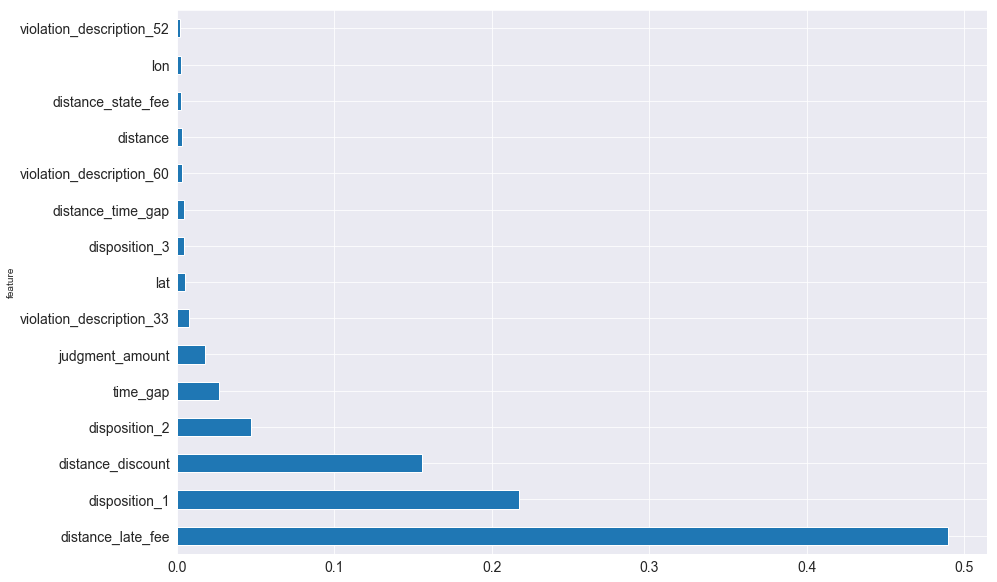

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt

clf = GradientBoostingClassifier(random_state = 0).fit(x_no_multi, y)

features = []

for feature, importance in zip(x_no_multi.columns, clf.feature_importances_):
    features.append((importance, feature))

features.sort(reverse = True)
features_relevant = [x_no_multi[1] for x_no_multi in features if x_no_multi[0] > 0]

features = pd.DataFrame()

features['feature'] = x_no_multi.columns
features['importance'] = clf.feature_importances_

features.sort_values(by = ['importance'], ascending = True, inplace = True)
features.set_index('feature', inplace = True)

# plot the 'top 15' features
features[:-16:-1].plot(kind = 'barh', figsize = (15, 10), legend = None)
plt.gcf().subplots_adjust(left=0.15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.show()

In [23]:
# import test data
test_df_01 = pd.read_csv('test.csv', delimiter = ',', encoding = 'latin-1', low_memory = False)

In [24]:
# apply the same transformations as done on the training data
test_df_02 = pd.merge(test_df_01, addresses, left_on = ['ticket_id'], right_on = ['ticket_id'], how = 'inner')
test_df_03 = pd.merge(test_df_02, latlons, left_on = ['address'], right_on = ['address'], how = 'inner')
    
for feature in features_to_reduce:
    number_categories_before = test_df_03[feature].value_counts(dropna = False).to_frame().shape[0]
    counts = test_df_03[feature].value_counts()
    test_df_03.loc[test_df_03[feature].isin(counts[counts < 10].to_frame().reset_index()['index']), feature] = np.nan
    number_categories_after = test_df_03[feature].value_counts(dropna = False).to_frame().shape[0]

test_df_03['time_gap'] = test_df_03.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis = 1).astype(np.float64)
test_df_03['time_gap'] = np.where((test_df_03['time_gap'] < 0) | (test_df_03['time_gap'] > 365), np.nan, test_df_03['time_gap'])
test_df_03['time_gap'].fillna(mean_time_gap, inplace = True)

test_df_03['lat'].fillna(mean_lat, inplace = True)
test_df_03['lon'].fillna(mean_lon, inplace = True)
test_df_03['state'].fillna('ZZ', inplace = True)

test_df_03['distance'] = test_df_03.apply(lambda row: haversine(lon1 = -83.045753, lat1 = 42.331429, lon2 = row['lon'], lat2 = row['lat']), axis = 1)

test_df_03['distance2'] = test_df_03['distance'] * test_df_03['distance']
test_df_03['distance_admin_fee'] = test_df_03['distance'] * test_df_03['admin_fee']
test_df_03['distance_state_fee'] = test_df_03['distance'] * test_df_03['state_fee']
test_df_03['distance_late_fee'] = test_df_03['distance'] * test_df_03['late_fee']
test_df_03['distance_discount'] = test_df_03['distance'] * test_df_03['discount_amount']
test_df_03['distance_judgment'] = test_df_03['distance'] * test_df_03['judgment_amount']
test_df_03['distance_time_gap'] = test_df_03['distance'] * test_df_03['time_gap']

test_df_03['violation_description'] = test_df_03['violation_description'].map(violation_description_dict2)
test_df_03['violation_description'].fillna(mode_violation_description, inplace = True)
test_df_03['violation_description'] = test_df_03['violation_description'].astype(np.int8)

test_df_03['agency_name'] = test_df_03['agency_name'].map(agency_name_dict2)
test_df_03['agency_name'].fillna(mode_agency_name, inplace = True)
test_df_03['agency_name'] = test_df_03['agency_name'].astype(np.int8)

test_df_03['disposition'] = test_df_03['disposition'].map(disposition_dict2)
test_df_03['disposition'].fillna(mode_disposition, inplace = True)
test_df_03['disposition'] = test_df_03['disposition'].astype(np.int8)

test_df_03['state'] = test_df_03['state'].map(state_dict2)
test_df_03['state'].fillna(49, inplace = True)
test_df_03['state'] = test_df_03['state'].astype(np.int8)

test_df_03 = pd.get_dummies(test_df_03, columns = feature_to_be_splitted)

test_df_03 = test_df_03.set_index('ticket_id')

In [25]:
# make sure the algorithm is not being trained on features not available in the test set - prevent data leakage
train_features = x_no_multi[features_relevant].columns
train_features_set = set(train_features)
    
for feature in set(train_features):
    if feature not in test_df_03:
        train_features_set.remove(feature)
train_features = list(train_features_set)
    
x_input = x[train_features]
test_df_03 = test_df_03[train_features]

In [26]:
x_input.shape, test_df_03.shape

((159880, 53), (61001, 53))

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

x_train, x_val, y_train, y_val = train_test_split(x_input, y, random_state = 0)

clf = GradientBoostingClassifier(learning_rate = 0.03, max_depth = 5, random_state = 0).fit(x_train, y_train)

# area under the curve (AUC) score for training dataset
y_train_score = clf.predict_proba(x_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_score)
    
# area under the curve (AUC) score for test dataset
y_val_score = clf.predict_proba(x_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_score)

print('ROC for training set: ', "{0:.3f}".format(roc_auc_train))
print('ROC for the validation set: ', "{0:.3f}".format(roc_auc_val))

ROC for training set:  0.824
ROC for the validation set:  0.814


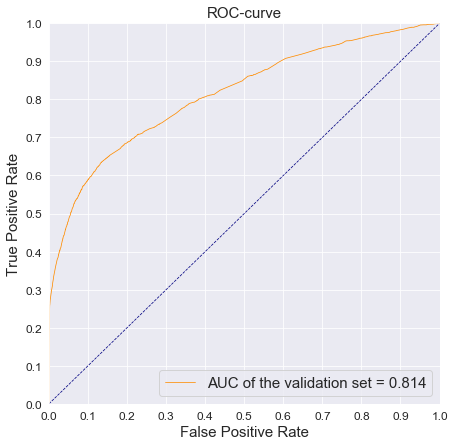

In [28]:
# plot the ROC-curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_val, y_val_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7, 7))

ax = plt.gca()

plt.title('ROC-curve', fontsize = 15)
plt.plot(fpr, tpr, color = 'darkorange', lw = 0.75, label = 'AUC of the validation set = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 0.75, linestyle = '--')

xticks_major = np.round(np.linspace(0, 1, 11), 1)
xticks_major_str = (xticks_major).astype(str).tolist()
xticks_labels = [x for x in xticks_major_str]

yticks_major = np.round(np.linspace(0, 1, 11), 1)
yticks_major_str = (yticks_major).astype(str).tolist()
yticks_labels = [x for x in yticks_major_str]

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks(xticks_major)
ax.set_xticklabels(xticks_labels, fontsize = 12)
ax.set_yticks(yticks_major)
ax.set_yticklabels(yticks_labels, fontsize = 12)

plt.ylabel('True Positive Rate', fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
plt.legend(loc=4, prop={'size': 15})
plt.show()

In [29]:
# the final predictions for the test set
prediction_proba = clf.predict_proba(test_df_03)[:,1]
test_df_03['compliance'] = prediction_proba.astype(np.float32)
test_df_03.compliance.head()

ticket_id
284932    0.068401
285362    0.021421
285361    0.047902
285338    0.065524
285346    0.075429
Name: compliance, dtype: float32